Julia

Comenzaremos usando Julia y lo primero que haremos será importar los paquetes necesarios para que funcione el programa.

In [ ]:
import Pkg;
Pkg.add("DeconvOptim")
Pkg.add("TestImages")
Pkg.add("Colors")
Pkg.add("ImageIO")
Pkg.add("Noise")
Pkg.add("ImageShow")
Pkg.add("Images")
Pkg.add("FFTW")

Una vez importados los paquetes lo que hemos hecho ha sido coger una imagen de prueba, añadirla borrosidad y ruido y hacer la deconvolución en 2D sin regularizar.
Usaremos la misma PSF para el código en python y el mismo número de iteraciones.

  1.493849 seconds (1.27 M allocations: 380.983 MiB, 4.53% gc time, 60.18% compilation time)
  0.691434 seconds (5.83 k allocations: 172.576 MiB, 6.89% gc time)


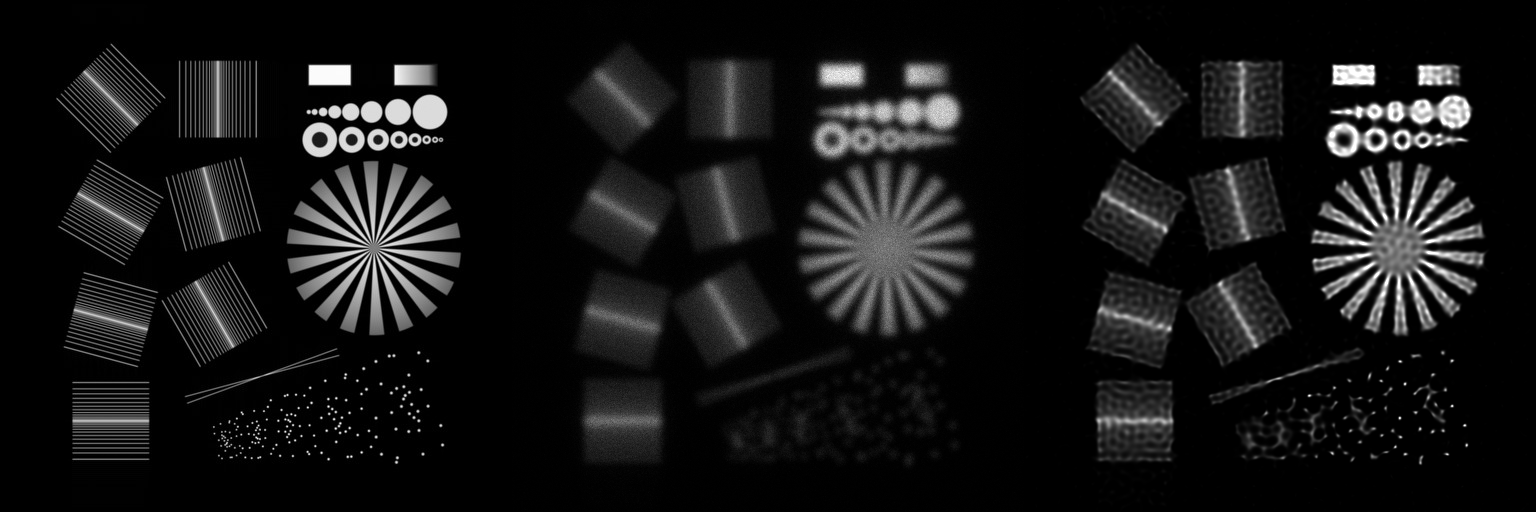

In [2]:
using DeconvOptim, TestImages, Colors, ImageIO, Noise, ImageShow, Images

# load test image
#img = Float32.(testimage("resolution_test_512"))
img = load("ImagenPrueba.jpg")
img = Float32.(img)
# generate simple Point Spread Function of aperture radius 30
psf = Float32.(generate_psf(size(img), 30))

# create a blurred, noisy version of that image
img_b = conv(img, psf) #blurred
img_n = poisson(img_b, 300) #blurred and noisy

#save("blurrednoisy_img.jpg", img_b)

# deconvolve 2D with default options
@time res, o = deconvolution(img_n, psf)

# deconvolve 2D with no regularizer
@time res_no_reg, o = deconvolution(img_n, psf, regularizer=nothing, iterations=30)

# show final results next to original and blurred version
Gray.([img img_n res_no_reg])

Ahora vamos a usar la función richardson_lucy_iterative del módulo deconvoptim.jl sin regularización.

  2.056660 seconds (267.24 k allocations: 24.330 MiB, 48.39% gc time, 90.64% compilation time)


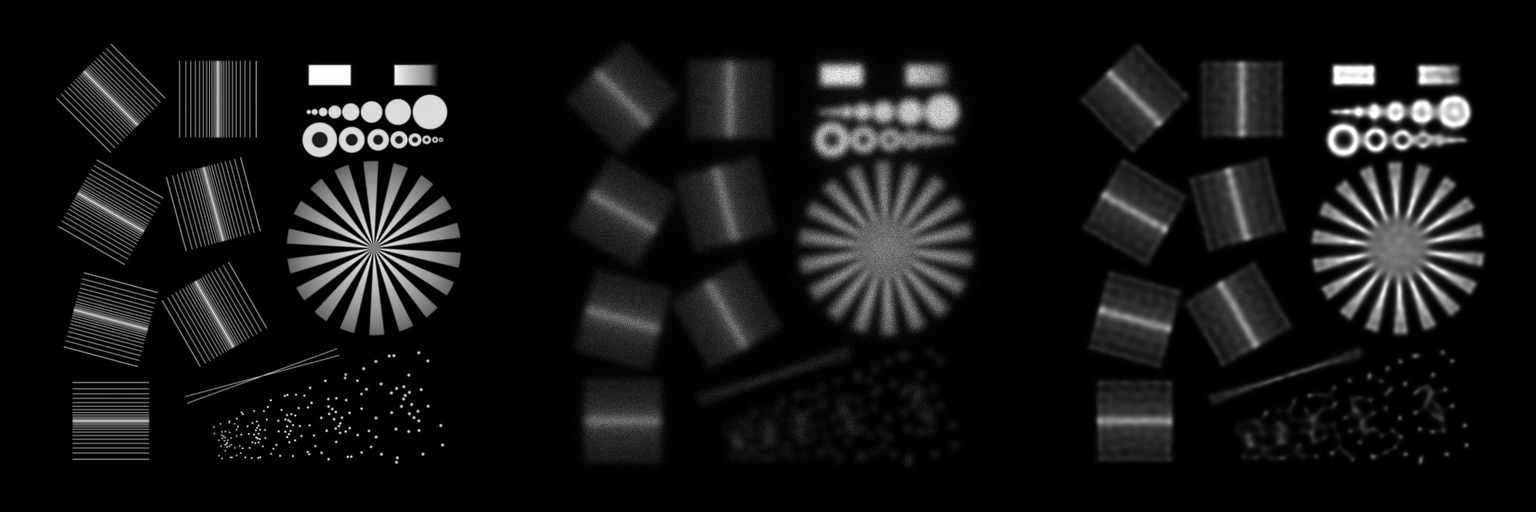

In [3]:
@time restored_img = richardson_lucy_iterative(img_n, psf; regularizer=nothing, iterations=30)
Gray.([img img_n restored_img])

Veremos ahora ejemplos con TV regularization en Julia

Python

In [ ]:
pip install numpy matplotlib scipy scikit-image imageio

942 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


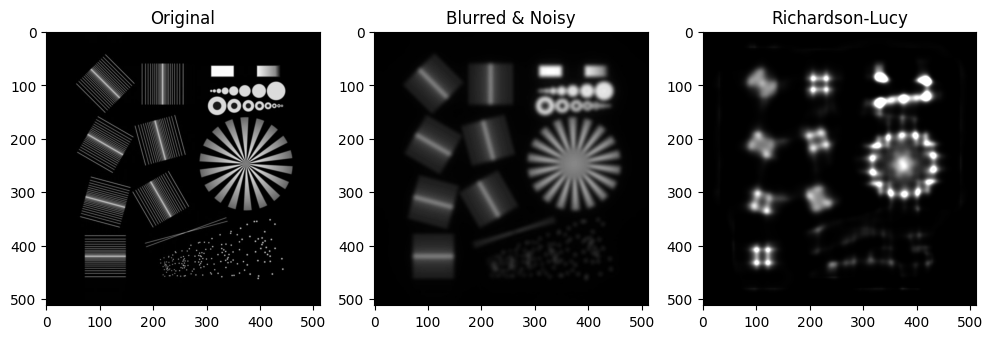

2.5054900646209717


In [3]:
import numpy as np
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.metrics import peak_signal_noise_ratio
from skimage.restoration import richardson_lucy
import imageio.v2 as iio
from skimage.util import random_noise
import time

inicio = time.time()
# Load test image
img = img_as_float(iio.imread("ImagenPrueba.jpg"))

# Generate simple Point Spread Function of aperture radius 30
def generate_psf(shape, radius):
    y, x = np.mgrid[-radius:radius+1, -radius:radius+1]
    psf = np.exp(-(x**2 + y**2)/(2.0*radius**2))
    return psf / np.sum(psf)

psf = generate_psf(img.shape, 30)


# Create a blurred version of the image
#img_b = convolve2d(img, psf, mode='same', boundary='wrap')
# Add noise to the blurred image
#img_n = np.random.poisson(img_b * 300) / 300.0
#img_n = random_noise(img_b, mode='poisson', rng=np.random.default_rng(0))


# Cargamos la imagen borrosa y con ruido de Julia

img_n = img_as_float(iio.imread("blurrednoisy_img.jpg"))

%timeit -n 1 -r 1 richardson_lucy(img_n, psf, num_iter=30)
# Deconvolve the image using Richardson-Lucy algorithm
res = richardson_lucy(img_n, psf, num_iter=30)

# Display original, blurred, and deconvolved images
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original')

plt.subplot(1, 3, 2)
plt.imshow(img_n, cmap='gray')
plt.title('Blurred & Noisy')

plt.subplot(1, 3, 3)
plt.imshow(res, cmap='gray')
plt.title('Richardson-Lucy')

plt.show()

fin = time.time()
print(fin-inicio)

Ahora veremos ejemplos con TV regularization en Python